# ULMFiT on French Amazon Customer Reviews
### (architecture AWD-LSTM, spaCy tokenizer)

- Author: [Pierre Guillou](https://www.linkedin.com/in/pierreguillou)
- Date: September 2019
- Post in medium: [link](https://medium.com/@pierre_guillou/nlp-fastai-french-language-model-d0e2a9e12cab)
- Ref: [Fastai v1](https://docs.fast.ai/) (Deep Learning library on PyTorch)

**Information**

According to this new article "[MultiFiT: Efficient Multi-lingual Language Model Fine-tuning](https://arxiv.org/abs/1909.04761)" (September 10, 2019), the QRNN architecture and the SentencePiece tokenizer give better results than AWD-LSTM and the spaCy tokenizer respectively. 

However, we wanted to check if it is true with the French language. Therefore, we have used an architecture AWD-LSTM and the spaCy tokenizer in this notebook to **fine-tune a French Bidirectional Language Model** by Transfer Learning of a French Bidirectional Language Model (with the AWD-LSTM architecture and the spaCy tokenizer, too) trained on a Wikipedia corpus of 100 millions tokens ([lm-french.ipynb](https://github.com/piegu/language-models/blob/master/lm-french.ipynb)). 

This French Bidirectional Language Model has been **fine-tuned on "[French Amazon Customer Reviews](https://s3.amazonaws.com/amazon-reviews-pds/readme.html)"** and **its encoder part has been transfered to a sentiment classifier which has been finally trained on this amazon corpus**.

This process **LM General --> LM fine-tuned --> Classifier fine-tuned** is called [ULMFiT](http://nlp.fast.ai/category/classification.html).

The following hyperparameters values have been used:
- Language Model
    - (batch size) bs = 128
    - (QRNN) 3 AWD-LSTM (default: 3) with 1152 hidden parameters each one (default: 1152)
    - (spaCy) vocab of 60 000 tokens with min_freq = 2
    - (dropout) mult_drop = 1.0 (except for the forward: 1.0 for the first 2 epochs and then 0.3)
    - (weight decay) wd = 0.01
    - (number of training epochs) 10 epochs


- Sentiment Classifier
    - (batch size) bs = 128
    - (spaCy) vocab of 60 000 tokens with min_freq = 2
    - (dropout) mult_drop = 0.5
    - (weight decay) wd = 0.01
    - (number of training epochs) 10 epochs
    - (loss) FlattenedLoss of weighted CrossEntropyLoss (the FlattenedLoss of LabelSmoothing CrossEntropy has been tested but was not kept because of a lower accuracy that could be a consequence of the fact that the dataset is unbalanced)

## Results

Our Bidirectional French LM ([lm-french.ipynb](https://github.com/piegu/language-models/blob/master/lm-french.ipynb)) and Sentiment Classifier with a AWD-LSTM architecture and using the spaCy tokenizer ([lm-french-classifier-amazon.ipynb](https://github.com/piegu/language-models/blob/master/lm-french-classifier-amazon.ipynb)) have better results (accuracy, perplexity and f1) than the Bidirectional French LM ([lm2-french.ipynb](https://github.com/piegu/language-models/blob/master/lm2-french.ipynb)) and Sentiment Classifier with a QRNN architecture and using the SentencePiecce tokenizer ([lm2-french-classifier-amazon.ipynb](https://github.com/piegu/language-models/blob/master/lm2-french-classifier-amazon.ipynb)). 

But because of the "To be improved" paragraph, we should retrain all in order to get a final comparaison.

### French Bidirectional LM (AWD-LSTM, spaCy)

- **About the data**: the dataset "French Amazon Customer Reviews" is unbalanced. Therefore, we used a weighted loss function (FlattenedLoss of weighted CrossEntropyLoss).
    - neg: 25637 (11.1%)
    - pos: 205047 (88.9%)
  

- **Accuracy and Perplexity** of the fine-tuned Language Model:    
    - forward : (accuracy) 33.93% | (perplexity) 34.08
    - backward: (global) 38.54% | (perplexity) 36.70


- **Accuracy** of the sentiment classifier:
    - forward : (global) 95.15% | **(neg) 93.73%** | (pos) 95.33% 
    - backward: (global) 95.85% | (neg) 91.62% | **(pos) 96.38%**
    - ensemble: **(global) 95.97%** | (neg) 92.95% | (pos) 96.35%


- **f1 score** of the sentiment classifier:
    - forward: 0.9722
    - backward: 0.9761
    - ensemble: **0.9770**
    

(neg = negative reviews | pos = positive reviews)

### To be improved

Out of the 230 684 reviews of our file amazon_reviews_fr.csv, we found (but after the training of our models) that **11 098 reviews are not in French: almost 5%** (4.8%)!

We should delete these 11 098 review and re-fine-tune our LM and after our sentiment classifier on the only-French reviews dataset.

## Initialisation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *
from fastai.callbacks import *

In [2]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1))

In [3]:
# bs=48
# bs=24
bs=128

In [4]:
torch.cuda.set_device(0)

In [5]:
data_path = Config.data_path()

This will create a `{lang}wiki` folder, containing a `{lang}wiki` text file with the wikipedia contents. (For other languages, replace `{lang}` with the appropriate code from the [list of wikipedias](https://meta.wikimedia.org/wiki/List_of_Wikipedias).)

In [6]:
lang = 'fr'

In [7]:
name = f'{lang}wiki'
path = data_path/name

mdl_path = path/'models'
lm_fns = [f'{lang}_wt', f'{lang}_wt_vocab']

## Data

- [French Amazon Customer Reviews](https://s3.amazonaws.com/amazon-reviews-pds/readme.html)
- [Guide on how to download the French Amazon Customer Reviews](https://forums.fast.ai/t/ulmfit-french/29379/36)
- File: amazon_reviews_multilingual_FR_v1_00.tsv.gz

In [8]:
name = 'amazon_reviews_fr'
path_data = data_path/name
path_data.ls()

[PosixPath('/home/jupyter/.fastai/data/amazon_reviews_fr/amazon_reviews_multilingual_FR_v1_00.tsv'),
 PosixPath('/home/jupyter/.fastai/data/amazon_reviews_fr/amazon_reviews_fr.csv')]

### Run this code the first time

In [16]:
# to solve display error of pandas dataframe
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [17]:
fields = ['review_id', 'review_body', 'star_rating']
df = pd.read_csv(path_data/'amazon_reviews_multilingual_FR_v1_00.tsv', delimiter='\t',encoding='utf-8', usecols=fields)
df = df[fields]
df.loc[pd.isna(df.review_body),'review_body']='NA'
df.head()

,review_id,review_body,star_rating
0,R32VYUWDIB5LKE,je conseille fortement ce bouquin à ceux qui s...,5
1,R3CCMP4EV6HAVL,"ce magnifique est livre , les personnages sont...",5
2,R14NAE6UGTVTA2,Je dirais qu'il a un défaut :<br />On ne peut ...,3
3,R2E7QEWSC6EWFA,Je l'ai depuis quelques jours et j'en suis trè...,4
4,R26E6I47GQRYKR,"je m'attendait à un bon film, car j'aime beauc...",2


In [18]:
# number of reviews
print(f'number of reviews: {len(df)}')

# check that there is no twice the same review
same = len(df) - len(df['review_id'].unique())
print(f'number of identical reviews: {same}')

# number of reviews neg or pos
num_neg_pos = len(df[df['star_rating'] != 3])
print(f'number of reviews neg + pos (rating != 3): {num_neg_pos}')

number of reviews: 253961
number of identical reviews: 0
number of reviews neg + pos (rating != 3): 230684


In [20]:
list(df_trn_val['label'].value_counts().array)

[205047, 25637]

pos    205047
neg     25637
Name: label, dtype: int64


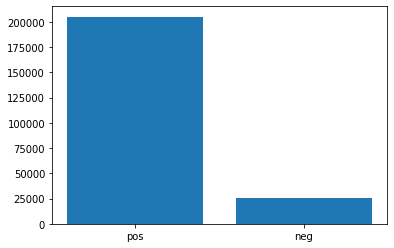

In [21]:
# categorify reviews in 2 classes neg, pos in the label column (rating != 3)
df_trn_val = df[df['star_rating'] != 3].copy()
df_trn_val['label'] = 'neg'
df_trn_val.loc[df_trn_val['star_rating'] > 3, 'label'] = 'pos'

# plot histogram
x= [1,2]
keys = list(df_trn_val['label'].value_counts().keys())
values = list(df_trn_val['label'].value_counts().array)
plt.bar(x, values) 
plt.xticks(x, keys)
print(df_trn_val['label'].value_counts())
plt.show()

In [38]:
df_trn_val.to_csv (path_data/'amazon_reviews_fr.csv', index = None, header=True)

### Get the csv of pre-processed data

In [9]:
df_trn_val = pd.read_csv(path_data/'amazon_reviews_fr.csv')

## Fine-tuning "forward LM"

### Databunch

In [22]:
%%time
data_lm = (TextList.from_df(df_trn_val, path, cols='review_body')
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1))

CPU times: user 19 s, sys: 5.55 s, total: 24.6 s
Wall time: 2min 6s


In [23]:
data_lm.save(f'{path}/fr_databunch_lm_aws')

### Training

In [16]:
data_lm = load_data(path, f'{lang}_databunch_lm_aws', bs=bs)

In [17]:
%%time
learn_lm = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult=1.0)

CPU times: user 2.61 s, sys: 476 ms, total: 3.08 s
Wall time: 1.86 s


In [25]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


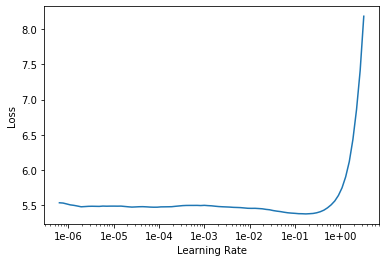

In [26]:
learn_lm.recorder.plot()

In [27]:
lr = 1e-3
lr *= bs/48

In [28]:
learn_lm.fit_one_cycle(2, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.702538,4.367174,0.253847,11:04
1,4.400340,4.088420,0.274744,11:04


In [29]:
learn_lm.save(f'{lang}fine_tuned1')
learn_lm.save_encoder(f'{lang}fine_tuned1_enc')

In [30]:
%%time
learn_lm = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult=0.3).to_fp16()

CPU times: user 2.46 s, sys: 484 ms, total: 2.95 s
Wall time: 1.81 s


In [31]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


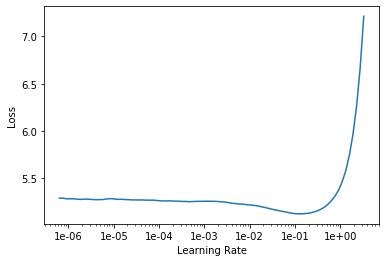

In [32]:
learn_lm.recorder.plot()

In [33]:
lr = 1e-3
lr *= bs/48

In [34]:
learn_lm.fit_one_cycle(2, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.353186,4.250944,0.264330,04:44
1,4.051137,3.964792,0.287635,04:44


In [35]:
learn_lm.save(f'{lang}fine_tuned2')
learn_lm.save_encoder(f'{lang}fine_tuned2_enc')

In [36]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.770283,3.778300,0.308042,05:09
1,3.712768,3.708468,0.316250,05:08
2,3.644494,3.656960,0.322486,05:09
3,3.548094,3.608242,0.328028,05:07
4,3.462411,3.565606,0.333361,05:07
5,3.370466,3.536912,0.337327,05:07
6,3.274147,3.525923,0.339292,05:09
7,3.212389,3.528762,0.339344,05:09


In [41]:
# perplexity
val_loss = 3.528762
np.exp(val_loss)

34.08174828200654

In [42]:
learn_lm.save(f'{lang}fine_tuned3')
learn_lm.save_encoder(f'{lang}fine_tuned3_enc')

In [18]:
learn_lm.load(f'{lang}fine_tuned3')
learn_lm.save(f'{lang}fine_tuned')
learn_lm.save_encoder(f'{lang}fine_tuned_enc')

## Fine-tuning "backward LM"

### Databunch

In [22]:
%%time
data_lm = (TextList.from_df(df_trn_val, path, cols='review_body')
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1, backwards=True))

CPU times: user 19 s, sys: 5.55 s, total: 24.6 s
Wall time: 2min 6s


In [23]:
data_lm.save(f'{path}/fr_databunch_lm_bwd_aws')

### Training

In [16]:
data_lm = load_data(path, f'{lang}_databunch_lm_bwd_aws', bs=bs, backwards=True)

In [13]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, config={**awd_lstm_lm_config, 'n_hid': 1152},
                                  pretrained_fnames=lm_fns, drop_mult=1.0)

In [14]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


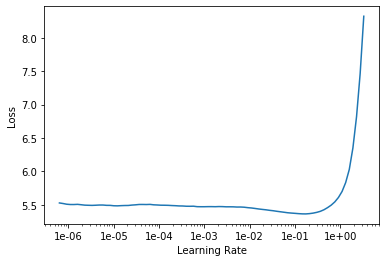

In [15]:
learn_lm.recorder.plot()

In [16]:
lr = 1e-3
lr *= bs/48

In [17]:
learn_lm.fit_one_cycle(2, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.735993,4.399763,0.306667,10:52
1,4.425303,4.154100,0.324668,10:54


In [18]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.083103,3.941800,0.347965,12:14
1,3.953619,3.823244,0.361522,12:16
2,3.902712,3.748363,0.369781,12:15
3,3.835884,3.696421,0.374707,12:14
4,3.765792,3.655543,0.379425,12:13
5,3.701114,3.622638,0.382914,12:13
6,3.677685,3.605838,0.384975,12:15
7,3.647490,3.602722,0.385406,12:16


In [37]:
# perplexity
val_loss = 3.602722
np.exp(val_loss)

36.697990544293184

In [19]:
learn_lm.save(f'{lang}fine_tuned_bwd')
learn_lm.save_encoder(f'{lang}fine_tuned_enc_bwd')

## Fine-tuning "forward Classifier"

In [ ]:
bs = 128

### Databunch

In [27]:
%%time
data_lm = load_data(path, f'{lang}_databunch_lm_aws', bs=bs)

CPU times: user 2.16 s, sys: 408 ms, total: 2.56 s
Wall time: 2.56 s


In [43]:
%%time
data_clas = (TextList.from_df(df_trn_val, path, vocab=data_lm.vocab, cols='review_body')
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols='label')
    .databunch(bs=bs, num_workers=1))

CPU times: user 23.2 s, sys: 14.3 s, total: 37.6 s
Wall time: 2min 18s


In [44]:
%%time
data_clas.save(f'{lang}_textlist_class')

CPU times: user 5.36 s, sys: 1.03 s, total: 6.39 s
Wall time: 5.9 s


### Get weights to penalize loss function of the majority class

In [28]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class', bs=bs, num_workers=1)

CPU times: user 11.7 s, sys: 620 ms, total: 12.3 s
Wall time: 12.2 s


In [29]:
num_trn = len(data_clas.train_ds.x)
num_val = len(data_clas.valid_ds.x)
num_trn, num_val, num_trn+num_val

(207616, 23068, 230684)

In [30]:
trn_LabelCounts = np.unique(data_clas.train_ds.y.items, return_counts=True)[1]
val_LabelCounts = np.unique(data_clas.valid_ds.y.items, return_counts=True)[1]
trn_LabelCounts, val_LabelCounts

(array([ 23071, 184545]), array([ 2566, 20502]))

In [31]:
trn_weights = [1 - count/num_trn for count in trn_LabelCounts]
val_weights = [1 - count/num_val for count in val_LabelCounts]
trn_weights, val_weights

([0.888876579839704, 0.11112342016029597],
 [0.8887636552800416, 0.11123634471995836])

### Training (Loss = FlattenedLoss of weighted CrossEntropyLoss)

In [61]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class', bs=bs, num_workers=1)

CPU times: user 12.6 s, sys: 284 ms, total: 12.9 s
Wall time: 12.8 s


In [12]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc');

#### Change loss function

In [13]:
learn_c.loss_func

FlattenedLoss of CrossEntropyLoss()

In [14]:
loss_weights = torch.FloatTensor(trn_weights).cuda()
learn_c.loss_func = partial(F.cross_entropy, weight=loss_weights)

In [15]:
learn_c.loss_func

functools.partial(<function cross_entropy at 0x7f70d551b170>, weight=tensor([0.8889, 0.1111], device='cuda:0'))

#### Training

In [16]:
learn_c.freeze()

In [17]:
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


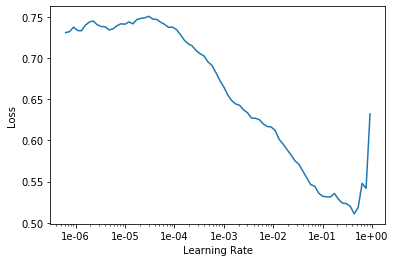

In [18]:
learn_c.recorder.plot()

In [17]:
lr = 2e-2
lr *= bs/48

In [20]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.295659,0.225372,0.909095,0.945840,03:39
1,0.269761,0.208683,0.906451,0.944137,02:51


In [21]:
learn_c.save(f'{lang}clas1')

In [22]:
learn_c.load(f'{lang}clas1');
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.302821,0.235026,0.939657,0.965035,02:22
1,0.285290,0.202845,0.914687,0.949297,02:52


In [23]:
learn_c.save(f'{lang}clas2')

In [24]:
learn_c.load(f'{lang}clas2');
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.245811,0.214268,0.868563,0.919026,04:22
1,0.209962,0.471603,0.941607,0.965826,02:48


In [25]:
learn_c.save(f'{lang}clas3')

In [18]:
learn_c.load(f'{lang}clas3');
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.199713,0.561943,0.911956,0.946469,02:45
1,0.161562,0.178816,0.945162,0.967920,02:45


In [19]:
learn_c.save(f'{lang}clas4')

In [20]:
learn_c.load(f'{lang}clas4');
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.131269,0.150057,0.951491,0.971827,03:23


In [21]:
learn_c.save(f'{lang}clas5')

In [22]:
learn_c.load(f'{lang}clas5')
learn_c.save(f'{lang}clas')

### Confusion matrix

In [32]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class', bs=bs, num_workers=1)

learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, 
                                  metrics=[accuracy,f1])
learn_c.load_encoder(f'{lang}fine_tuned_enc');

learn_c.load(f'{lang}clas');

# put weight on cpu
loss_weights = torch.FloatTensor(trn_weights).cpu()
learn_c.loss_func = partial(F.cross_entropy, weight=loss_weights)

CPU times: user 15.6 s, sys: 1.56 s, total: 17.1 s
Wall time: 14.9 s


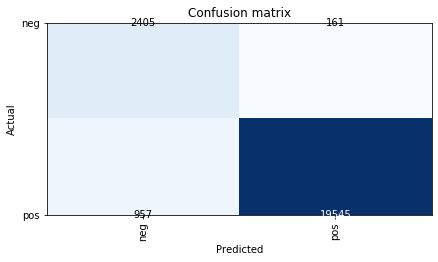

In [33]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.array(y), np.array(predictions))
print(cm)

## acc
print(f'accuracy global: {(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])}')

# acc neg, acc pos
print(f'accuracy on negative reviews: {cm[0,0]/(cm[0,0]+cm[0,1])*100}') 
print(f'accuracy on positive reviews: {cm[1,1]/(cm[1,0]+cm[1,1])*100}')

[[ 2405   161]
 [  957 19545]]
accuracy global: 0.9515345933761055
accuracy on negative reviews: 93.72564302416212
accuracy on positive reviews: 95.3321627158326


In [35]:
learn_c.show_results()

text,target,prediction
"xxbos http : / / www.amazon.co.uk / xxmaj sony - xxmaj bernstein - xxmaj edition / forum / xxunk / xxunk / xxunk = xxunk = xxup xxunk \n \n ainsi que sa liste en espérant \n [ xxmaj disc 1 ] \n xxup js xxmaj bach : "" xxmaj no . 2 in e major xxmaj violin xxmaj concerto xxup xxunk "" \n [ xxmaj",pos,pos
"xxbos xxmaj voila une intégrale bienvenue que xxup decca sort judicieusement de ses cartons , ce ne sont que des enregistrements de qualité de l'immense pianiste ( do nt de nombreux introuvables ) . xxmaj ses concertos de xxmaj beethoven avec xxmaj knappertsbusch sont fabuleux tout comme les deux concertos de xxmaj brahms , pour moi la meilleure version jamais enregistrée . xxmaj vous entendrez également des variations xxmaj xxunk",pos,pos
"xxbos xxmaj même si je vais me faire des ennemis , je persiste et signe , xxmaj pierce xxmaj brosnan est crédible dans le rôle , xxmaj sean xxmaj connery l'acteur fondateur du rôle titre , donc intouchable , xxmaj george xxmaj xxunk et xxmaj xxunk xxmaj dalton , crédibles malgré un passage très court ( 1 film pour le premier et 2 pour le second ) . xxmaj l'acteur",pos,pos
"xxbos xxmaj waouh , au boulot . xxmaj je reçois ce bloc ( divin , salut xxmaj xxunk ! ) - et , je le souligne , à 20 euros de moins que proposé ici en passant par un vendeur d'amazon xxup uk - alors même que xxunk ( xxunk depuis un moment , je suis xxunk débordé ) les 40 xxup cd du coffret xxup emi xxmaj cortot .",pos,neg
"xxbos xxmaj tout y est , l'histoire , la réalisation du très grand xxup ridley xxup scott , xxmaj les acteurs et surtout xxup russell xxup crowe , xxmaj les xxmaj décors , enfin tout et surtout en version longue . \n \n xxmaj gladiator ( ou xxmaj gladiateur au xxmaj québec et au xxmaj nouveau - xxmaj xxunk ) est un film américano - britannique de xxmaj ridley",pos,pos


In [36]:
# Trying out some random sentences I made up

review = 'Ce produit est bizarre.'
pred = learn_c.predict(review)
print(pred[0], pred[2])

neg tensor([0.9959, 0.0041])


## Fine-tuning "backward Classifier"

In [ ]:
bs = 128

### Databunch

In [27]:
%%time
data_lm = load_data(path, f'{lang}_databunch_lm_bwd_aws', bs=bs, backwards=True)

CPU times: user 2.16 s, sys: 408 ms, total: 2.56 s
Wall time: 2.56 s


In [ ]:
%%time
data_clas = (TextList.from_df(df_trn_val, path, vocab=data_lm.vocab, cols='review_body')
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols='label')
    .databunch(bs=bs, num_workers=1, backwards=True))

data_clas.save(f'{path}/{lang}_textlist_class_bwd')

### Get weights to penalize loss function of the majority class

In [38]:
data_clas = load_data(path, f'{lang}_textlist_class_bwd', bs=bs, num_workers=1, backwards=True)

In [39]:
num_trn = len(data_clas.train_ds.x)
num_val = len(data_clas.valid_ds.x)
num_trn, num_val, num_trn+num_val

(207616, 23068, 230684)

In [40]:
trn_LabelCounts = np.unique(data_clas.train_ds.y.items, return_counts=True)[1]
val_LabelCounts = np.unique(data_clas.valid_ds.y.items, return_counts=True)[1]
trn_LabelCounts, val_LabelCounts

(array([ 23071, 184545]), array([ 2566, 20502]))

In [41]:
trn_weights = [1 - count/num_trn for count in trn_LabelCounts]
val_weights = [1 - count/num_val for count in val_LabelCounts]
trn_weights, val_weights

([0.888876579839704, 0.11112342016029597],
 [0.8887636552800416, 0.11123634471995836])

### Training (Loss = FlattenedLoss of weighted CrossEntropyLoss)

In [9]:
data_clas = load_data(path, f'{lang}_textlist_class_bwd', bs=bs, num_workers=1, backwards=True)

In [14]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc_bwd');

#### Change loss function

In [15]:
learn_c.loss_func

FlattenedLoss of CrossEntropyLoss()

In [16]:
loss_weights = torch.FloatTensor(trn_weights).cuda()
learn_c.loss_func = partial(F.cross_entropy, weight=loss_weights)

In [17]:
learn_c.loss_func

functools.partial(<function cross_entropy at 0x7f81a9f7a9e0>, weight=tensor([0.8889, 0.1111], device='cuda:0'))

#### Training

In [18]:
learn_c.freeze()

In [19]:
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


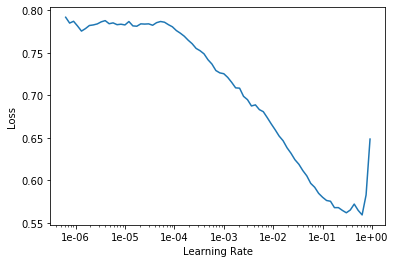

In [20]:
learn_c.recorder.plot()

In [21]:
lr=2e-2
lr *= bs/48

In [22]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.348143,0.272712,0.926738,0.957417,02:01
1,0.281248,0.239874,0.884039,0.929876,01:58


In [23]:
learn_c.save(f'{lang}clas1_bwd')

In [24]:
learn_c.load(f'{lang}clas1_bwd');
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.236988,0.181851,0.923010,0.954649,02:14
1,0.184165,0.160263,0.948370,0.969995,02:13


In [25]:
learn_c.save(f'{lang}clas2_bwd')

In [26]:
learn_c.load(f'{lang}clas2_bwd');
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.205938,0.249031,0.954699,0.973841,02:47
1,0.144008,0.728798,0.951144,0.971714,02:48


In [27]:
learn_c.save(f'{lang}clas3_bwd')

In [28]:
learn_c.load(f'{lang}clas3_bwd');
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.125825,0.166620,0.958514,0.976108,03:22


In [29]:
learn_c.save(f'{lang}clas_bwd')

### Confusion matrix

In [42]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_bwd', bs=bs, num_workers=1, backwards=True)

learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1])
learn_c.load_encoder(f'{lang}fine_tuned_enc_bwd');

learn_c.load(f'{lang}clas_bwd');

# put weight on cpu
loss_weights = torch.FloatTensor(trn_weights).cpu()
learn_c.loss_func = partial(F.cross_entropy, weight=loss_weights)

CPU times: user 16.3 s, sys: 1.4 s, total: 17.7 s
Wall time: 20.5 s


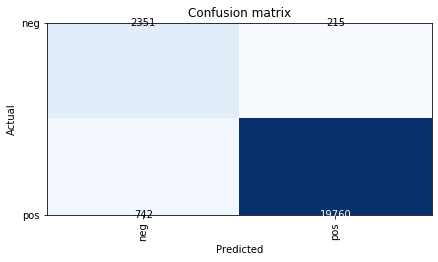

In [43]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.array(y), np.array(predictions))
print(cm)

## acc
print(f'accuracy global: {(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])}')

# acc neg, acc pos
print(f'accuracy on negative reviews: {cm[0,0]/(cm[0,0]+cm[0,1])*100}') 
print(f'accuracy on positive reviews: {cm[1,1]/(cm[1,0]+cm[1,1])*100}')

[[ 2351   215]
 [  742 19760]]
accuracy global: 0.9585139587307092
accuracy on negative reviews: 91.62120031176929
accuracy on positive reviews: 96.38084089357136


In [45]:
learn_c.show_results()

text,target,prediction
"m : "" figaro xxmaj of marriage xxmaj the xxmaj "" overture xxmaj ) 1968 , york xxmaj new xxmaj , 5 march xxmaj ( \n ] xxunk xxmaj [ \n \n philharmonic xxmaj york xxmaj new xxmaj ] playing xxmaj [ \n ferrari xxmaj = w : "" madonna xxmaj of jewel "" interlude - ) 1968 , 2 february xxmaj unknown xxmaj ( \n",pos,pos
"curzon xxmaj clifford xxmaj \n xxunk troppo non ma allegro xxmaj . xxunk \n xxunk ) xxunk con vivace allegro xxmaj ( scherzo xxmaj . 3 . 49 \n xxunk sostenuto andante xxmaj . 2 . 48 \n xxunk moderato molto xxmaj . 1 . 47 \n xxunk xxup , flat b in xxunk xxmaj sonata xxmaj piano xxmaj \n xxunk ) moderato allegro",pos,pos
""" \ name xxmaj my xxmaj know xxmaj you xxmaj "" \ pour visuel média autre un ou télévision la , cinéma le pour écrite chanson meilleure : 2008 awards xxmaj grammy xxmaj \n xxunk xxmaj stuart xxmaj pour dramatique xxunk montage meilleur : 2007 awards xxmaj eddie xxmaj \n xxunk poursuite - course la pour scène meilleure : 2007 awards xxmaj empire xxmaj \n haggis xxmaj",pos,pos
") . inconnu asin xxup numéro , introuvable , là de partir à ensuite recherchez le vous si , mais asin xxup numéro un article cet pour indique nous on , surcroît par xxmaj ! xxunk xxmaj carrément , aussi s'écrit cela , à échappé même quand a on mais ... xxunk non , xxunk xxmaj est indiqué compositeur le / 2 et pianiste du nom le pas même signale",pos,pos
". morricone xxmaj ennio xxmaj par musique en mis , sahara xxmaj the of secret xxmaj the xxmaj , 1988 de téléfilm d'un thème un reprend scène même cette de fin la à intervient qui lent morceau le , enfin xxmaj . scott xxmaj ridley xxmaj de préféré films des l'un , xxunk xxmaj film au emprunté est d'ouverture scène la de germain guerre de chant le xxmaj . wagner",pos,pos


In [46]:
# Trying out some random sentences I made up

review = 'Ce produit est bizarre.'
pred = learn_c.predict(review)
print(pred[0], pred[2])

neg tensor([0.9982, 0.0018])


## Ensemble

In [ ]:
bs = 128

In [47]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class', bs=bs, num_workers=1)
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c.load(f'{lang}clas', purge=False);

CPU times: user 15.6 s, sys: 976 ms, total: 16.6 s
Wall time: 14.4 s


RNNLearner(data=TextClasDataBunch;

Train: LabelList (207616 items)
x: TextList
xxbos je conseille fortement ce bouquin à ceux qui sont intéressé par ce genre de sujets , en plus le prix est vraiment abordable . 
 
  xxup r. xxmaj dawkins au sommet,xxbos ce magnifique est livre , les personnages sont hors normes , intrigue totale et absolue , a lire absolument ! !,xxbos xxmaj je l'ai depuis quelques jours et j'en suis très heureuse 
  compte bien les pas , bonne synchronisation avec l'appli 
  et facile d'utilisation .,xxbos je m'attendait à un bon film , car j'aime beaucoup le réalisateur , mais j'ai été très déçu : il n'y a pas beaucoup d'action n'y de suspens 
  xxmaj je trouve le film trop long pour le peu à dire ... dommage,xxbos xxmaj ne disait pas sur l'annonce que c'était un 10 ' , seulement xxmaj vinyl xxmaj album . xxmaj j'était vraiment deçu , mais pour des raisons xxunk n'était pas possible de changer .
y: CategoryList
pos,pos,pos,neg,neg
Path: /home/jupyter/.fastai/data/fr

In [48]:
preds,targs = learn_c.get_preds(ordered=True)
accuracy(preds,targs),f1(preds,targs)

(tensor(0.9515), tensor(0.9722))

In [49]:
%%time
data_clas_bwd = load_data(path, f'{lang}_textlist_class_bwd', bs=bs, num_workers=1, backwards=True)
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c_bwd.load(f'{lang}clas_bwd', purge=False);

CPU times: user 15.7 s, sys: 1.18 s, total: 16.8 s
Wall time: 14.1 s


RNNLearner(data=TextClasDataBunch;

Train: LabelList (207616 items)
x: TextList
xxbos je conseille fortement ce bouquin à ceux qui sont intéressé par ce genre de sujets , en plus le prix est vraiment abordable . 
 
  xxup r. xxmaj dawkins au sommet,xxbos ce magnifique est livre , les personnages sont hors normes , intrigue totale et absolue , a lire absolument ! !,xxbos xxmaj je l'ai depuis quelques jours et j'en suis très heureuse 
  compte bien les pas , bonne synchronisation avec l'appli 
  et facile d'utilisation .,xxbos je m'attendait à un bon film , car j'aime beaucoup le réalisateur , mais j'ai été très déçu : il n'y a pas beaucoup d'action n'y de suspens 
  xxmaj je trouve le film trop long pour le peu à dire ... dommage,xxbos xxmaj ne disait pas sur l'annonce que c'était un 10 ' , seulement xxmaj vinyl xxmaj album . xxmaj j'était vraiment deçu , mais pour des raisons xxunk n'était pas possible de changer .
y: CategoryList
pos,pos,pos,neg,neg
Path: /home/jupyter/.fastai/data/fr

In [50]:
preds_b,targs_b = learn_c_bwd.get_preds(ordered=True)
accuracy(preds_b,targs_b),f1(preds_b,targs_b)

(tensor(0.9585), tensor(0.9764))

In [51]:
preds_avg = (preds+preds_b)/2

In [52]:
accuracy(preds_avg,targs_b),f1(preds_avg,targs_b)

(tensor(0.9597), tensor(0.9770))

In [53]:
from sklearn.metrics import confusion_matrix

predictions = np.argmax(preds_avg, axis = 1)
cm = confusion_matrix(np.array(targs_b), np.array(predictions))
print(cm)

## acc
print(f'accuracy global: {(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])}')

# acc neg, acc pos
print(f'accuracy on negative reviews: {cm[0,0]/(cm[0,0]+cm[0,1])*100}') 
print(f'accuracy on positive reviews: {cm[1,1]/(cm[1,0]+cm[1,1])*100}')

[[ 2385   181]
 [  749 19753]]
accuracy global: 0.9596844113057049
accuracy on negative reviews: 92.94621979734995
accuracy on positive reviews: 96.34669788313334
